## Params
start dates of each interval and end date. 

In [1]:
import os
import re
from datetime import datetime

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns


from pyspark import SQLContext
from pyspark.sql.functions import input_file_name, regexp_extract, concat
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [3]:
start_date = '20180301'
end_date = '20190228'
midterm = '20181001'
lastQuarter = '20181201'
base = './data'

# Read files
I will take the files from the analytix HDFS (in order to use it in swan without copy the files)

In [4]:
# local directory for the phedex dataset (gz)
phedexInput = os.path.join(base, "popularity/phedex_{}_{}.csv.gz".format(start_date, end_date))
eventsInput = os.path.join(base, "popularity/dbs_events.csv.gz")

# HDFS location of dbs events input dataframe 
dbsInput = "/cms/dbs_condor/dataset/201*/*/*/part-*"

# Take into account only replicas in T1 and T2 sites. 
onlyT1_T2 = True

In [5]:
sc

<SparkContext master=yarn appName=pyspark_shell_swan>

# Read  dbs_condor dataset

This dataset, stored in hdfs, will be the base to determine the use of the datasets.

In [6]:
dbs_df = spark.read.csv(dbsInput, header=True)\
        .select(u'dataset', 'sum_evts')\
        .withColumn('filename',input_file_name())

## Filter the dataset

We are only interested on records with datasets. There should be no records with dataset and without events (but currently there are).

By default, spark takes empty strings as null. In the current version there are rendered as the "null" string instead of null value (this will change on another versions). 

In [7]:
# Are there records with dataset but without events (empty sum_evts in the original files)?
# - By default, spark takes empty string as null. 
# - In the current version there are rendered as the "null" string instead of null value (this will change on another versions). 

invalidRecords = dbs_df.filter('(dataset IS NOT NULL AND dataset != "null") AND (sum_evts IS NULL OR sum_evts = "null" OR sum_evts = "")')

In [8]:
invalidRecords.filter('sum_evts = ""').head(1)

[]

In [9]:
invalidRecords.count()

29487101

In [10]:
dbs_df = dbs_df.filter('dataset != "null" AND sum_evts !="null" AND sum_evts != ""')

In [11]:
zero = dbs_df.filter('sum_evts = "0.0"')
print(zero.count())
zero.head(5) #Should this be posible?

17302551


[Row(dataset=u'/ZeroBias8/Run2016F-v1/RAW', sum_evts=u'0.0', filename=u'hdfs://analytix/cms/dbs_condor/dataset/2018/01/23/part-00043'),
 Row(dataset=u'/SingleMuon/Run2017E-17Nov2017-v1/MINIAOD', sum_evts=u'0.0', filename=u'hdfs://analytix/cms/dbs_condor/dataset/2018/01/23/part-00043'),
 Row(dataset=u'/Tau/Run2016B-18Apr2017_ver2-v1/DQMIO', sum_evts=u'0.0', filename=u'hdfs://analytix/cms/dbs_condor/dataset/2018/01/23/part-00043'),
 Row(dataset=u'/ZeroBias8/Run2016F-v1/RAW', sum_evts=u'0.0', filename=u'hdfs://analytix/cms/dbs_condor/dataset/2018/01/23/part-00043'),
 Row(dataset=u'/ZeroBias1/Commissioning2017-v1/RAW', sum_evts=u'0.0', filename=u'hdfs://analytix/cms/dbs_condor/dataset/2018/01/23/part-00043')]

In [12]:
dbs_df = dbs_df.subtract(zero)

In [13]:
dbs_df = dbs_df.withColumn('events',dbs_df.sum_evts.cast("double")*1000)

In [14]:
dbs_df = dbs_df.withColumn('days',concat(regexp_extract(dbs_df.filename,'.*\/([0-9]{4})\/([0-9]{2})\/([0-9]{2})',1), 
                                         regexp_extract(dbs_df.filename,'.*\/([0-9]{4})\/([0-9]{2})\/([0-9]{2})',2), 
                                         regexp_extract(dbs_df.filename,'.*\/([0-9]{4})\/([0-9]{2})\/([0-9]{2})',3)))

In [15]:
dbs_df = dbs_df.filter('days between {} AND {}'.format(start_date, end_date))

In [16]:
dbs_df.limit(1).show()

+--------------------+--------+--------------------+--------+--------+
|             dataset|sum_evts|            filename|  events|    days|
+--------------------+--------+--------------------+--------+--------+
|/ST_tW_antitop_5f...| 242.678|hdfs://analytix/c...|242678.0|20180805|
+--------------------+--------+--------------------+--------+--------+



# Use of each dataset per day

In [17]:
_df_agg = dbs_df.groupBy('dataset','days').sum('events').alias('sum_events').toPandas()

In [18]:
_plain=_df_agg.rename(columns={u'days':'day',
                               u'sum(events)':'sum_events'})


In [19]:
# _plain.columns
_plain[_plain.sum_events==0].head()

,dataset,day,sum_events


## Calculate the effective average size of each dataset in the given periods
 size of each dataset in each of the time periods

In [20]:
_sizes = pd.read_csv(phedexInput)

In [21]:
if onlyT1_T2:
    _sizes = _sizes[np.logical_or(_sizes.site.str.startswith("T1_"),_sizes.site.str.startswith("T2_"))]

## The weight of the dataset in the given period is a weigthed average of the size of the replicas in that period


In [22]:
def weigthed_size(x,begin, end):
    """
    The first approach to calculate the weigth. It replicate the functionality of Carl's script.
    @param x row
    @param begin first day of the period.
    @param end last day of the period. 
    """
    if str(x.max_date) < str(begin) or str(x.min_date) > str(end):
        return 0
    _start = str(x.min_date) if str(begin)<str(x.min_date) else str(begin)
    _end = str(x.max_date) if str(end)>=str(x.max_date) else str(end)
    delta=(datetime.strptime(_end,'%Y%m%d')-datetime.strptime(_start,'%Y%m%d')).days+1.0
    period=(datetime.strptime(end,'%Y%m%d')-datetime.strptime(begin,'%Y%m%d')).days+1.0
    return float(delta)/float(period)

def weigthed_size_vectorized(x, begin,end):
    """
    A vectorized approach to calcule the weigth of a size in a given period.
    @param x dataset
    @param begin first day of the period.
    @param end last day of the period. 
    """
    _start = pd.Series(np.where(x.min_date.astype('str') >= str(begin),
                                x.min_date.astype('str'), str(begin)),
                       x.index)
    _end = pd.Series(np.where(x.max_date.astype('str') <str(end),
                              x.max_date.astype('str'), str(end)),
                     x.index)
    delta = (pd.to_datetime(_end,format='%Y%m%d') -
             pd.to_datetime(_start, format='%Y%m%d')).dt.days+1.0
    
    delta[np.logical_or(x.max_date.astype('str') < str(begin),
                        x.min_date.astype('str') > str(end))] = 0
    
    period = (datetime.strptime(end,'%Y%m%d') - 
              datetime.strptime(begin,'%Y%m%d')).days + 1.0 

    return np.true_divide(delta.astype(np.float32),period)

In [23]:
#_w=_sizes.apply(lambda x:weigthed_size(x,midterm,end_date), axis=1 )
_w = weigthed_size_vectorized(_sizes,midterm,end_date)
_sizes['weight_6Month']=_w
_sizes['weighted_size_6Month']=_sizes.ave_size*_w

#_w=_sizes.apply(lambda x:weigthed_size(x,lastQuarter,end_date), axis=1 )
_w = weigthed_size_vectorized(_sizes,lastQuarter,end_date)
#print _w
_sizes['weight_3Month']=_w
_sizes['weighted_size_3Month']=_sizes.ave_size*_w

#_w=_sizes.apply(lambda x:weigthed_size(x,start_date,end_date), axis=1 )
_w = weigthed_size_vectorized(_sizes,start_date,end_date)
_sizes['weight_12Month']=_w
_sizes['weighted_size_12Month']=_sizes.ave_size*_w



In [24]:
_sizes.min_date=_sizes.rdate

In [25]:
_df_dsSzDur = _sizes.groupby('dataset').agg({'min_date':'min',
                                             'max_date':'max',
                                             'weighted_size_3Month':'sum',
                                             'weighted_size_6Month':'sum',
                                             'weighted_size_12Month':'sum'})


In [26]:
_events = pd.read_csv(eventsInput)

In [27]:
_events[['dataset','nevents']].head()

,dataset,nevents
0,/RandomTriggers/BeamCommissioning08-v1/RAW,10073306
1,/Cosmics/Commissioning08_CRAFT_ALL_V4_SuperPoi...,938338
2,/Cosmics/Commissioning08-CruzetAll_FU_L1Basic-...,8863574
3,/QCD250to500-madgraph/Winter09_IDEAL_V12_FastS...,121492634
4,/Calo/HAPPYHAPPYWARMFUZZY_T0TEST_WITHBUNNIESDA...,118536698


In [28]:
df_dsSzDur = pd.merge(_df_dsSzDur, _events[['dataset','nevents']], on='dataset')

In [29]:
df_dsSzDur=df_dsSzDur.rename(columns={'weighted_size_12Month': 'size12month', 
                                      'weighted_size_3Month':'size3month',
                                      'weighted_size_6Month': 'size6month',
                                      'max_date':'end',
                                      'min_date':'begin',
                                      u'nevents':'nEvents' })

In [30]:
df_dsSzDur.columns

Index([u'dataset', u'size12month', u'size3month', u'size6month', u'end',
       u'begin', u'nEvents'],
      dtype='object')

## Join the datasets

A inner join to keep only the used datasets. 

In [31]:
_merged = pd.merge(df_dsSzDur, _plain, on='dataset', sort=True) 


In [32]:
# Rate of the events used over the number of events in the file
_merged['rate'] = _merged.sum_events/_merged.nEvents

In [33]:
_merged.head()

,dataset,size12month,size3month,size6month,end,begin,nEvents,day,sum_events,rate
0,/ADDGravToGG_MS-10000_NED-2_KK-1_M-1000To2000_...,1.050660e+10,1.101456e+10,1.101136e+10,20190228,20170812,100000,20181106,100000.0,1.0
1,/ADDGravToGG_MS-10000_NED-2_KK-1_M-2000To4000_...,1.044827e+10,1.129133e+10,1.035321e+10,20190228,20170901,99998,20181106,99998.0,1.0
2,/ADDGravToGG_MS-10000_NED-2_KK-1_M-4000To10000...,9.406279e+09,8.253106e+09,8.253106e+09,20190228,20170215,96530,20181106,96530.0,1.0
3,/ADDGravToGG_MS-10000_NED-2_KK-1_M-500To1000_1...,8.553156e+09,9.211354e+09,9.298736e+09,20190228,20171016,99586,20181106,99586.0,1.0
4,/ADDGravToGG_MS-10000_NED-2_KK-1_M-500To1000_1...,2.606524e+09,7.153243e+09,6.300539e+09,20190228,20181018,99586,20190124,99586.0,1.0


## Create the desired datasets. 

The datasets sixMnts, threeMnts and twelveMnts contains only data for datasets that where used at least once in the given period. 

In [34]:
_merged.day = _merged.day.astype('str')
full = _merged
sixMnts = full[full.day>=midterm][['dataset', 'size6month', 'day', 'rate']]
threeMnts = full[(full.day>=lastQuarter)][['dataset', 'size3month', 'day','rate']]
twelveMnts = full[['dataset', 'size12month', 'day', 'rate']][np.logical_not(np.isnan(full.rate))]

In [35]:
_merged.size3month.head()

0    1.101456e+10
1    1.129133e+10
2    8.253106e+09
3    9.211354e+09
4    7.153243e+09
Name: size3month, dtype: float32

## Sum the event usage rate


In [36]:
sum_3mth = threeMnts.groupby(['dataset','size3month']).agg({'rate':'sum'})
sum_6mth = sixMnts.groupby(['dataset','size6month']).agg({'rate':'sum'})
sum_12mth = twelveMnts.groupby(['dataset','size12month']).agg({'rate':'sum'})
types = {'3 months':sum_3mth, '6 months':sum_6mth, 'full year':sum_12mth}
cols = {'3 months':'size3month', '6 months':'size6month', 'full year':'size12month'}
bdates = {'3 months':lastQuarter, '6 months':midterm, 'full year':start_date}

In [37]:
gp = None

In [38]:

for _type in types.keys():
    _sum = types[_type].reset_index()
    
    # positive values <1 belong to the first bin  (one accesss). 
    _sum.rate = np.where(np.logical_and(_sum.rate<1, _sum.rate>0),1,_sum.rate) 
    # if there are 0 or  negative values they should be in another bin (-currently there are none-). 
    _sum.rate = np.where(_sum.rate<=0, -1, _sum.rate) 
    _sum['rtceil'] = np.round(_sum.rate).astype(np.int)
    
    _sum.rtceil = np.where(_sum.rtceil>14, 15, _sum.rtceil)
    _sum.rtceil = _sum.rtceil.astype(str)
    _sum.rtceil = _sum.rtceil.map(lambda x:x.rjust(2,'0'))

    # Group higher values
    _sum.rtceil.values[_sum.rtceil=='15'] = '15+'
    
    #
    _sum.rtceil.values[_sum.rtceil=='-1'] = '-Evts'
    
    # agregate per bin
    _gp =_sum.groupby('rtceil').agg({cols[_type]:['sum','count']})
    _gp.columns = _gp.columns.droplevel(0)
    _gp = _gp.reset_index()
    _gp.columns = ['bin','f_size','count_ds']
    
    # Unused data:
    # Unused data is data that exists (had a size>0) in the given period but is not in the sum dataframe 
    # (it was not used in the given period).
    _unused = df_dsSzDur[np.logical_and(np.logical_not(df_dsSzDur.dataset.isin(_sum.dataset)),
                                        df_dsSzDur[cols[_type]]>0)]
    # old
    # Unused old data is unused data that existed before the period begins
    _unused_old =  _unused.loc[_unused.begin.astype(str)<bdates[_type]]
    # new
    # Unused new data is unused data created on this period
    _unused_new =  _unused.loc[_unused.begin.astype(str)>=bdates[_type]]
    
    _gp = _gp.append(
        {'bin': '0-old',
        'f_size': np.sum(_unused_old[cols[_type]]),
        'count_ds': np.unique(_unused_old['dataset']).size},
        ignore_index=True)
    _gp = _gp.append(
        {'bin': '00-new',
        'f_size': np.sum(_unused_new[cols[_type]]),
        'count_ds': np.unique(_unused_new['dataset']).size},
        ignore_index=True)
    
    # We want values in PB
    _gp.f_size = _gp.f_size*(1024**-5)
    # And we want the total in the legend
    _gp["type"] = "{} {:.2f} PB".format(_type, _gp.f_size.sum())
    
    if gp is None:
        gp = _gp
    else:
        gp = pd.concat([gp,_gp],ignore_index=True)

In [39]:
values = gp.type.unique()
values.sort()

In [40]:
gp.head(18)

,bin,f_size,count_ds,type
0,01,30.440916,11007,6 months 97.49 PB
1,02,5.145459,2010,6 months 97.49 PB
2,03,3.045310,1126,6 months 97.49 PB
3,04,1.171057,758,6 months 97.49 PB
4,05,1.487681,548,6 months 97.49 PB
5,06,0.867081,390,6 months 97.49 PB
6,07,1.103685,271,6 months 97.49 PB
7,08,0.574791,184,6 months 97.49 PB
8,09,0.470140,152,6 months 97.49 PB
9,10,0.749886,133,6 months 97.49 PB


In [41]:
x_order = gp.bin.unique()
x_order.sort()

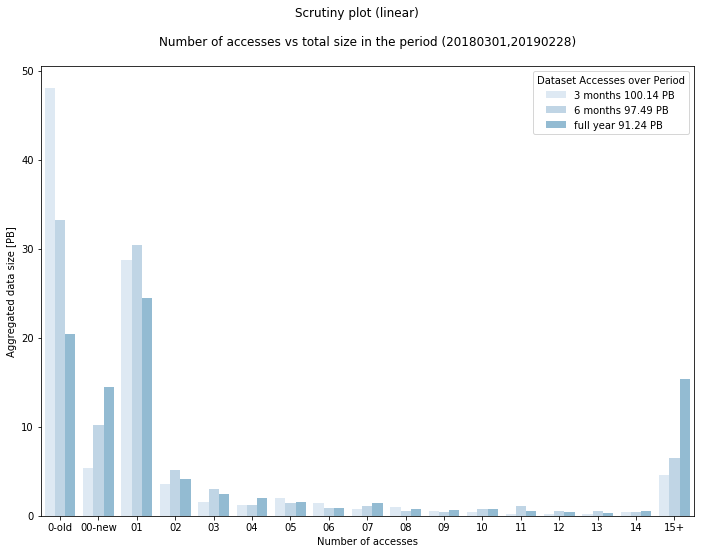

In [45]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.set_palette(sns.color_palette("Blues"))

plot=sns.barplot(x='bin',
                 y='f_size',
                 order=x_order,
                 hue='type',
                 hue_order=values,
                 data=gp,
                 ax=ax)

pyplot.xlabel("Number of accesses")
pyplot.ylabel("Aggregated data size [PB]")
pyplot.suptitle("Scrutiny plot (linear)")
pyplot.title("""
Number of accesses vs total size in the period ({},{})
""".format(start_date, end_date))
plot.legend(title="Dataset Accesses over Period")

In [43]:
sc.stop()

In [46]:
_directory = 'output'
_format = 'pdf'
if not os.path.exists(_directory):
    os.makedirs(_directory)
fig.savefig(os.path.join(_directory,'scrutiny{}-{}.{}'.format(start_date,end_date,_format)),format=_format)